In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from transformers import ViTModel, ViTConfig
import os
from tqdm import tqdm
from PIL import Image
import torch.nn.functional as F

class UNetGenerator(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(UNetGenerator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),  # 224x224 -> 112x112
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),             # 112x112 -> 56x56
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1),            # 56x56 -> 28x28
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1),            # 28x28 -> 14x14
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.middle = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=1, padding=1),  # Keeps size at 14x14
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=1, padding=1),  # Keeps size at 14x14
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 14x14 -> 28x28
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # 28x28 -> 56x56
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),   # 56x56 -> 112x112
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, output_channels, kernel_size=4, stride=2, padding=1),  # 112x112 -> 224x224
            nn.Tanh(),
        )

    def forward(self, x):
        # Encoder
        enc = self.encoder(x)
        #print(f"Shape after encoder: {enc.shape}")  # Check encoder output shape
        
        # Middle
        mid = self.middle(enc)
        #print(f"Shape after middle: {mid.shape}")  # Check shape after middle layer
        
        # Decoder
        dec = self.decoder(mid)
        #print(f"Shape after decoder: {dec.shape}")  # Final generator output shape
        return dec


class Discriminator(nn.Module):
    def __init__(self, input_channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 1, kernel_size=4, stride=2, padding=0),  # Ensures output is [B, 1, 1, 1]
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        return self.model(x)

# Dataset and DataLoader
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

class KITTIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = sorted([os.path.join(root_dir, img) for img in os.listdir(root_dir) if img.endswith('.png') or img.endswith('.jpg')])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, 0  # Dummy label as GANs don't require labels

dataset = KITTIDataset("/kaggle/input/kitti-dataset/data_object_image_2/training/image_2", transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


# Initialize Models
generator = UNetGenerator(input_channels=128, output_channels=3).cuda()
discriminator = Discriminator(input_channels=3).cuda()
vit_config = ViTConfig(hidden_size=128, num_attention_heads=4, num_hidden_layers=6)
vit_encoder = ViTModel(vit_config).cuda()

# Optimizers
opt_gen = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_disc = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss Functions
adversarial_loss = nn.BCELoss()
reconstruction_loss = nn.MSELoss()

# Training Loop
epochs = 100
for epoch in range(epochs):
    for real_images, _ in tqdm(dataloader):
        real_images = real_images.cuda()
        batch_size = real_images.size(0)
        valid = torch.ones((batch_size, 1)).cuda()
        fake = torch.zeros((batch_size, 1)).cuda()

        # Train Generator
        opt_gen.zero_grad()

        #print(f"Input shape: {real_images.shape}")  # Shape of input image batch

        # Get the output from ViT encoder
        output = vit_encoder(real_images).last_hidden_state
        #print(f"Output shape (ViT): {output.shape}")  # ViT encoder output
        
        # Exclude the CLS token
        patch_embeddings = output[:, 1:, :]  # Remove the CLS token
        #print(f"Patch embeddings shape: {patch_embeddings.shape}")  # After excluding CLS token
        
        # Reshape the output to feed into the generator
        num_patches = int(patch_embeddings.shape[1] ** 0.5)  # Compute square root of number of patches
        z = patch_embeddings.permute(0, 2, 1).view(batch_size, 128, num_patches, num_patches)
        #print(f"Final tensor shape (z): {z.shape}")  # After reshaping for generator

        # After shaping z to [batch, 128, 14, 14], upsample it:
        z_upsampled = F.interpolate(z, size=(224, 224), mode='bilinear', align_corners=False)
        gen_images = generator(z_upsampled)

        #print(f"Generated images shape: {gen_images.shape}")


        valid = torch.ones_like(discriminator(gen_images)).cuda()  # Match shape dynamically
        fake = torch.zeros_like(discriminator(gen_images)).cuda()  # Match shape dynamically


        #print(f"Discriminator output shape: {discriminator(gen_images).shape}")
        #print(f"Valid tensor shape: {valid.shape}")

        
        g_loss = adversarial_loss(discriminator(gen_images), valid) + reconstruction_loss(gen_images, real_images)
        g_loss.backward()
        opt_gen.step()

        # Train Discriminator
        opt_disc.zero_grad()
        real_loss = adversarial_loss(discriminator(real_images), valid)
        fake_loss = adversarial_loss(discriminator(gen_images.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        opt_disc.step()

    print(f"Epoch {epoch}/{epochs} | Generator Loss: {g_loss.item()} | Discriminator Loss: {d_loss.item()}")

    # Save model checkpoint
    if epoch % 10 == 0:
        torch.save(generator.state_dict(), f"generator_epoch_{epoch}.pth")


100%|██████████| 234/234 [03:01<00:00,  1.29it/s]


Epoch 0/100 | Generator Loss: 1.0204671621322632 | Discriminator Loss: 0.5757521390914917


100%|██████████| 234/234 [02:04<00:00,  1.88it/s]


Epoch 1/100 | Generator Loss: 0.8944224119186401 | Discriminator Loss: 0.6046009659767151


100%|██████████| 234/234 [02:09<00:00,  1.81it/s]


Epoch 2/100 | Generator Loss: 0.9148299098014832 | Discriminator Loss: 0.662074863910675


100%|██████████| 234/234 [02:08<00:00,  1.81it/s]


Epoch 3/100 | Generator Loss: 0.9174225926399231 | Discriminator Loss: 0.6196024417877197


100%|██████████| 234/234 [02:09<00:00,  1.81it/s]


Epoch 4/100 | Generator Loss: 0.8649089336395264 | Discriminator Loss: 0.6286202669143677


100%|██████████| 234/234 [02:11<00:00,  1.78it/s]


Epoch 5/100 | Generator Loss: 0.8477680683135986 | Discriminator Loss: 0.6478431224822998


100%|██████████| 234/234 [02:11<00:00,  1.78it/s]


Epoch 6/100 | Generator Loss: 0.8825801610946655 | Discriminator Loss: 0.6523526310920715


100%|██████████| 234/234 [02:08<00:00,  1.82it/s]


Epoch 7/100 | Generator Loss: 0.8609124422073364 | Discriminator Loss: 0.6547753810882568


100%|██████████| 234/234 [02:10<00:00,  1.79it/s]


Epoch 8/100 | Generator Loss: 0.8716676235198975 | Discriminator Loss: 0.676280677318573


100%|██████████| 234/234 [02:06<00:00,  1.84it/s]


Epoch 9/100 | Generator Loss: 0.7923703193664551 | Discriminator Loss: 0.6853745579719543


100%|██████████| 234/234 [02:06<00:00,  1.85it/s]


Epoch 10/100 | Generator Loss: 0.8484306335449219 | Discriminator Loss: 0.641687273979187


100%|██████████| 234/234 [02:05<00:00,  1.86it/s]


Epoch 11/100 | Generator Loss: 0.8051302433013916 | Discriminator Loss: 0.7096637487411499


100%|██████████| 234/234 [02:04<00:00,  1.88it/s]


Epoch 12/100 | Generator Loss: 0.8951003551483154 | Discriminator Loss: 0.6600557565689087


100%|██████████| 234/234 [02:04<00:00,  1.87it/s]


Epoch 13/100 | Generator Loss: 0.9105572700500488 | Discriminator Loss: 0.6478037238121033


100%|██████████| 234/234 [02:07<00:00,  1.84it/s]


Epoch 14/100 | Generator Loss: 0.9278598427772522 | Discriminator Loss: 0.6569019556045532


100%|██████████| 234/234 [02:06<00:00,  1.86it/s]


Epoch 15/100 | Generator Loss: 0.8418715596199036 | Discriminator Loss: 0.6609691977500916


100%|██████████| 234/234 [02:06<00:00,  1.85it/s]


Epoch 16/100 | Generator Loss: 0.8129839897155762 | Discriminator Loss: 0.673197865486145


100%|██████████| 234/234 [02:11<00:00,  1.78it/s]


Epoch 17/100 | Generator Loss: 0.8519625067710876 | Discriminator Loss: 0.6657014489173889


100%|██████████| 234/234 [02:07<00:00,  1.84it/s]


Epoch 18/100 | Generator Loss: 0.8247244954109192 | Discriminator Loss: 0.6730898022651672


100%|██████████| 234/234 [02:08<00:00,  1.82it/s]


Epoch 19/100 | Generator Loss: 0.8537623882293701 | Discriminator Loss: 0.6696504950523376


100%|██████████| 234/234 [02:07<00:00,  1.83it/s]


Epoch 20/100 | Generator Loss: 0.8032670021057129 | Discriminator Loss: 0.6897951364517212


100%|██████████| 234/234 [02:06<00:00,  1.85it/s]


Epoch 21/100 | Generator Loss: 0.8628685474395752 | Discriminator Loss: 0.6753075122833252


100%|██████████| 234/234 [02:08<00:00,  1.82it/s]


Epoch 22/100 | Generator Loss: 0.8021018505096436 | Discriminator Loss: 0.6760892868041992


 94%|█████████▎| 219/234 [01:57<00:08,  1.82it/s]

### Evaluation

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from transformers import ViTModel, ViTConfig
import os
from tqdm import tqdm
from PIL import Image
import torch.nn.functional as F

class UNetGenerator(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(UNetGenerator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),  # 224x224 -> 112x112
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),             # 112x112 -> 56x56
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1),            # 56x56 -> 28x28
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1),            # 28x28 -> 14x14
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.middle = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=1, padding=1),  # Keeps size at 14x14
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=1, padding=1),  # Keeps size at 14x14
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 14x14 -> 28x28
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # 28x28 -> 56x56
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),   # 56x56 -> 112x112
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, output_channels, kernel_size=4, stride=2, padding=1),  # 112x112 -> 224x224
            nn.Tanh(),
        )

    def forward(self, x):
        # Encoder
        enc = self.encoder(x)
        #print(f"Shape after encoder: {enc.shape}")  # Check encoder output shape
        
        # Middle
        mid = self.middle(enc)
        #print(f"Shape after middle: {mid.shape}")  # Check shape after middle layer
        
        # Decoder
        dec = self.decoder(mid)
        #print(f"Shape after decoder: {dec.shape}")  # Final generator output shape
        return dec


class Discriminator(nn.Module):
    def __init__(self, input_channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 1, kernel_size=4, stride=2, padding=0),  # Ensures output is [B, 1, 1, 1]
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        return self.model(x)

# Dataset and DataLoader
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

class KITTIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = sorted([os.path.join(root_dir, img) for img in os.listdir(root_dir) if img.endswith('.png') or img.endswith('.jpg')])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, 0  # Dummy label as GANs don't require labels

dataset = KITTIDataset("/kaggle/input/kitti-dataset/data_object_image_2/training/image_2", transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


# Initialize Models
generator = UNetGenerator(input_channels=128, output_channels=3).cuda()
discriminator = Discriminator(input_channels=3).cuda()
vit_config = ViTConfig(hidden_size=128, num_attention_heads=4, num_hidden_layers=6)
vit_encoder = ViTModel(vit_config).cuda()


/tmp/ipykernel_23/1491127918.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(model_path))


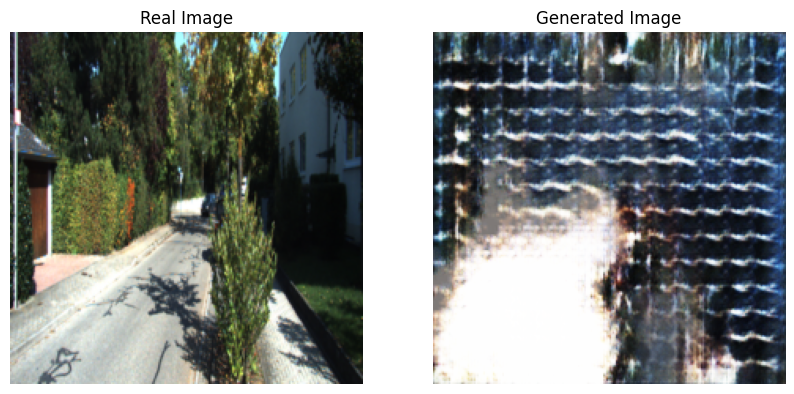

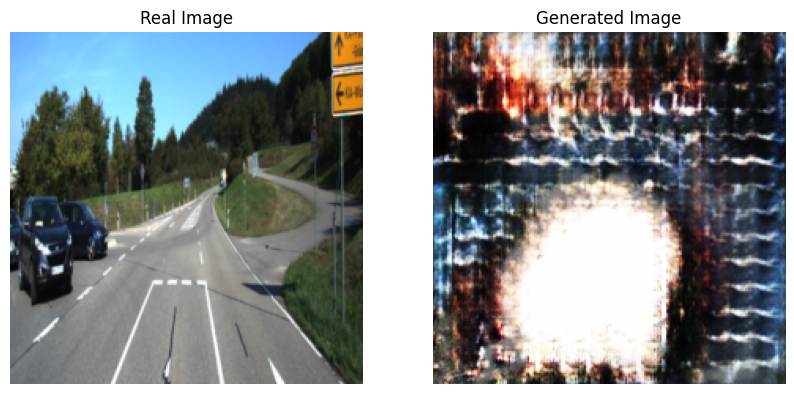

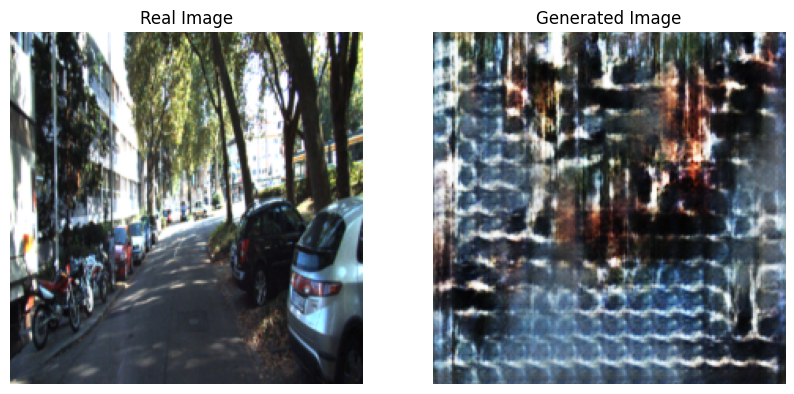

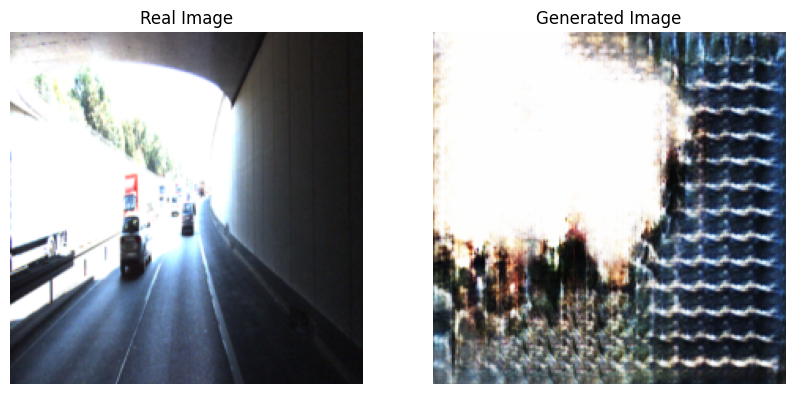

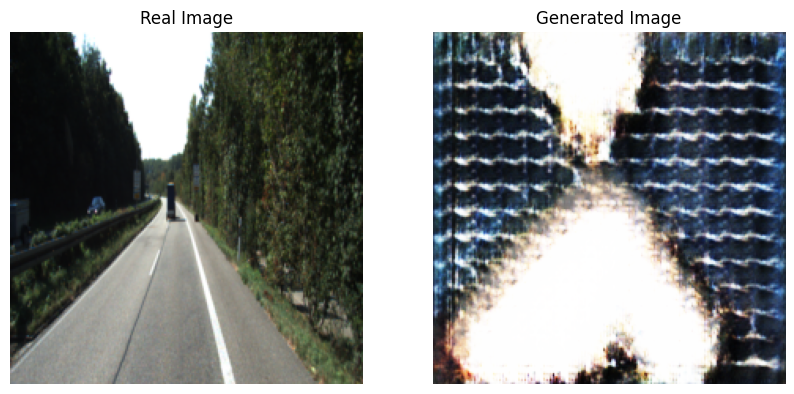

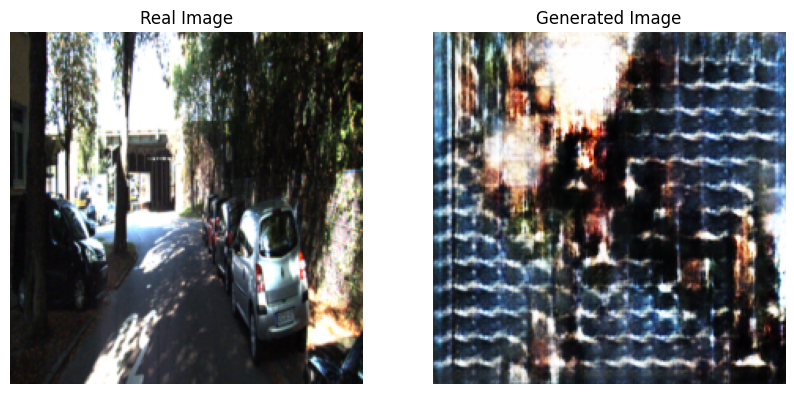

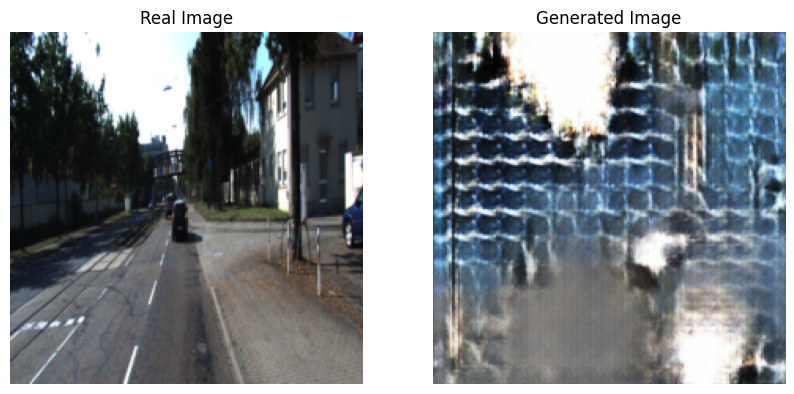

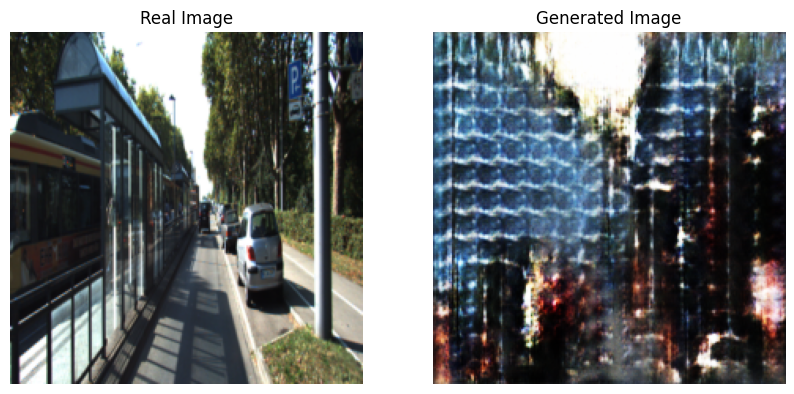

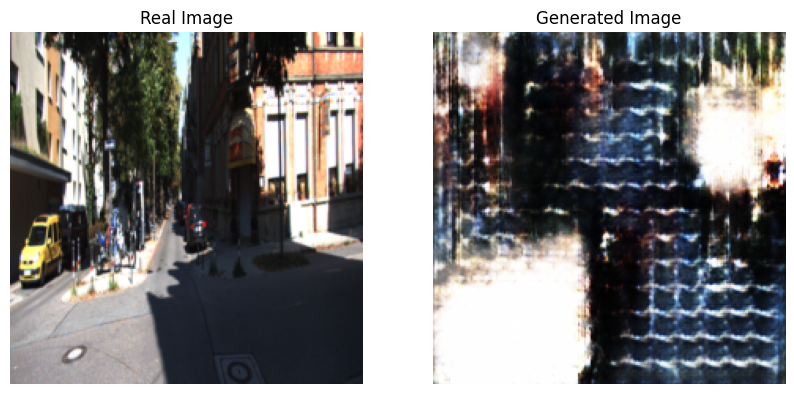

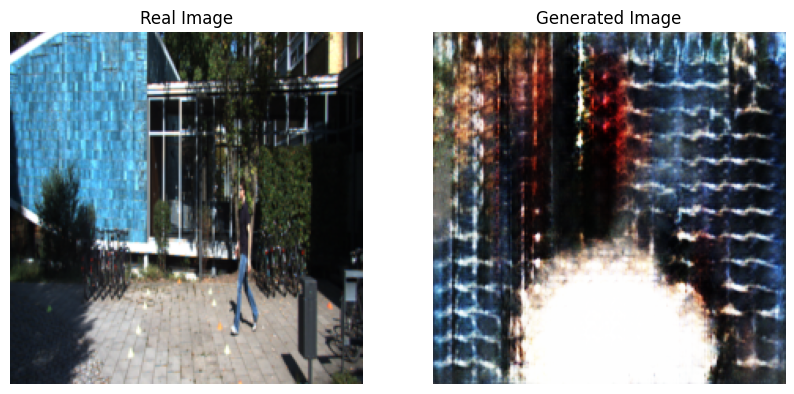

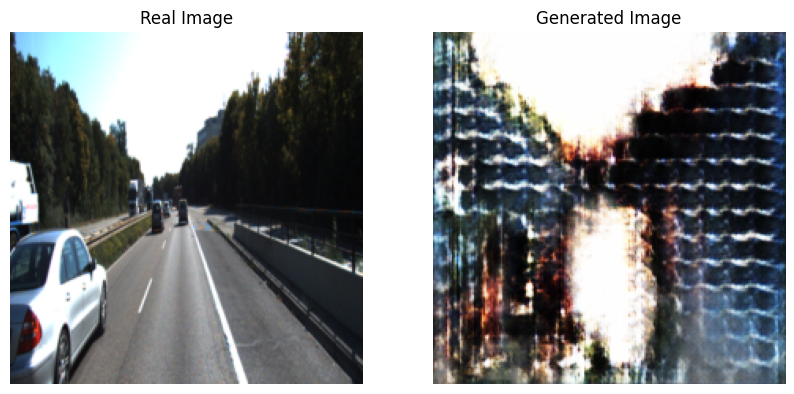

In [3]:
import matplotlib.pyplot as plt

# Define paths for the model and test dataset
model_path = "/kaggle/input/vit-unet-generator/generator_epoch_90.pth"  # Update with the actual path to the saved model
test_dataset_path = "/kaggle/input/kitti-dataset/data_object_image_2/testing/image_2"

# Load the generator model
generator = UNetGenerator(input_channels=128, output_channels=3).cuda()
generator.load_state_dict(torch.load(model_path))
generator.eval()  # Set the model to evaluation mode

# Define the test dataset and dataloader
test_dataset = KITTIDataset(test_dataset_path, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Function to denormalize the output images for visualization
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5  # Reverse normalization: [-1, 1] -> [0, 1]
    return tensor.clamp(0, 1)  # Clamp to ensure values are in valid range

# Evaluation loop
for idx, (real_images, _) in enumerate(test_dataloader):
    real_images = real_images.cuda()
    with torch.no_grad():
        # Pass the images through the ViT encoder
        output = vit_encoder(real_images).last_hidden_state
        patch_embeddings = output[:, 1:, :]
        num_patches = int(patch_embeddings.shape[1] ** 0.5)
        z = patch_embeddings.permute(0, 2, 1).view(1, 128, num_patches, num_patches)
        z_upsampled = F.interpolate(z, size=(224, 224), mode='bilinear', align_corners=False)
        
        # Generate images
        generated_images = generator(z_upsampled)

    # Denormalize images for visualization
    real_image = denormalize(real_images[0].cpu())
    generated_image = denormalize(generated_images[0].cpu())

    # Plot and visualize the results
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(real_image.permute(1, 2, 0))
    axes[0].set_title("Real Image")
    axes[0].axis("off")
    
    axes[1].imshow(generated_image.permute(1, 2, 0))
    axes[1].set_title("Generated Image")
    axes[1].axis("off")
    
    plt.show()
    
    if idx == 10:  # Visualize first 10 images only
        break


### Evaluation Metrics

In [5]:
!pip install scipy torchvision pytorch-fid

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [7]:
from pytorch_fid.fid_score import calculate_fid_given_paths
from torchvision.models.inception import inception_v3
from torchvision.transforms import ToPILImage
from scipy.linalg import sqrtm
import numpy as np

# Helper function to compute SSIM
from skimage.metrics import structural_similarity as ssim

def compute_ssim(real, generated):
    real_np = real.permute(1, 2, 0).cpu().numpy()
    generated_np = generated.permute(1, 2, 0).cpu().numpy()
    return ssim(real_np, generated_np, multichannel=True)

# Directories to store real and generated images for FID calculation
real_dir = "real_images"
fake_dir = "fake_images"
os.makedirs(real_dir, exist_ok=True)
os.makedirs(fake_dir, exist_ok=True)

# Prepare inception model for IS calculation
inception = inception_v3(pretrained=True, transform_input=False).eval().cuda()

def compute_inception_score(images, inception_model):
    logits = []
    for img in images:
        with torch.no_grad():
            logits.append(inception_model(img.unsqueeze(0).cuda()).cpu())
    logits = torch.cat(logits, dim=0)
    p_yx = torch.nn.functional.softmax(logits, dim=1).numpy()
    p_y = np.expand_dims(p_yx.mean(axis=0), axis=0)
    kl_div = p_yx * (np.log(p_yx + 1e-8) - np.log(p_y + 1e-8))
    score = np.exp(kl_div.sum(axis=1).mean())
    return score

# Evaluation loop for metrics
real_images_list, generated_images_list = [], []

for idx, (real_images, _) in enumerate(test_dataloader):
    real_images = real_images.cuda()
    with torch.no_grad():
        output = vit_encoder(real_images).last_hidden_state
        patch_embeddings = output[:, 1:, :]
        num_patches = int(patch_embeddings.shape[1] ** 0.5)
        z = patch_embeddings.permute(0, 2, 1).view(1, 128, num_patches, num_patches)
        z_upsampled = F.interpolate(z, size=(224, 224), mode='bilinear', align_corners=False)
        
        # Generate images
        generated_images = generator(z_upsampled)

    # Save real and generated images for FID calculation
    for real, gen in zip(real_images, generated_images):
        ToPILImage()(real.cpu()).save(f"{real_dir}/real_{idx}.png")
        ToPILImage()(gen.cpu()).save(f"{fake_dir}/fake_{idx}.png")
        real_images_list.append(real)
        generated_images_list.append(gen)

    if idx == 100:  # Limit evaluation to the first 100 images
        break

# FID Calculation
fid_score = calculate_fid_given_paths([real_dir, fake_dir], batch_size=32, device='cuda', dims=2048)
print(f"FID Score: {fid_score}")

# IS Calculation
inception_score = compute_inception_score(generated_images_list, inception)
print(f"Inception Score: {inception_score}")

100%|██████████| 4/4 [00:00<00:00,  6.88it/s]


FID Score: 290.3239952961115
Inception Score: 4.7957000732421875
